In [2]:
from keras.datasets import boston_housing


(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets.shape

(404,)

In [6]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

## data preprocessing

In [7]:
#normalizing the data to have a mean of 0 and sd of 1
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

##Building the network

In [8]:
from keras import models,layers

#we will be reusing this model since we are going to be doing k-fold validation
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu',
  input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [9]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
  [train_data[:i * num_val_samples],
  train_data[(i + 1) * num_val_samples:]],
  axis=0)
  partial_train_targets = np.concatenate(
  [train_targets[:i * num_val_samples],
  train_targets[(i + 1) * num_val_samples:]],
  axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
  epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
 all_scores

[2.0409996509552, 2.4155869483947754, 2.474848747253418, 2.288418769836426]

In [11]:
np.mean(all_scores)

2.304963529109955

In [12]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
  [train_data[:i * num_val_samples],
  train_data[(i + 1) * num_val_samples:]],
  axis=0)
  partial_train_targets = np.concatenate(
  [train_targets[:i * num_val_samples],
  train_targets[(i + 1) * num_val_samples:]],
  axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
  validation_data=(val_data, val_targets),
  epochs=num_epochs, batch_size=1, verbose=0)
  
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


##buidling the history of each successful k-fold

In [13]:
average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#plotting validation score


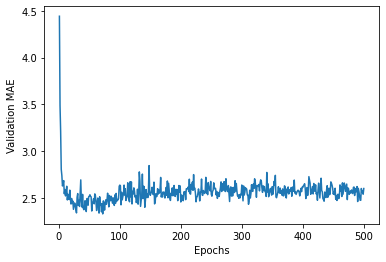

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [17]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])


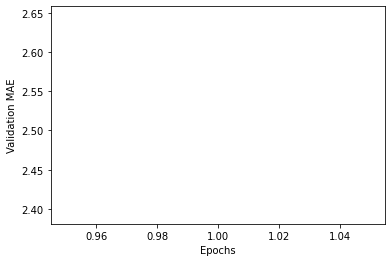

In [18]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


##training the model

In [19]:
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 19.4643 - mae: 2.8109


In [20]:
test_mae_score

2.8109490871429443